# Introduction

After completing our PCA and performing data reduction, we are ready to rerun our data models with our reduced and cleaned data, going from 33 attributes down to 20. From there, we agreed to train our data on the highest correlated attributes (famsup_yes/no, activities_yes/no, and G3). We will train our NN based on these four attributes.

Note that the PCA includes continuous data, which is why we use MLPRegressor.

This will include NN training on:

Input: activities, famsup, higher
Output: G3

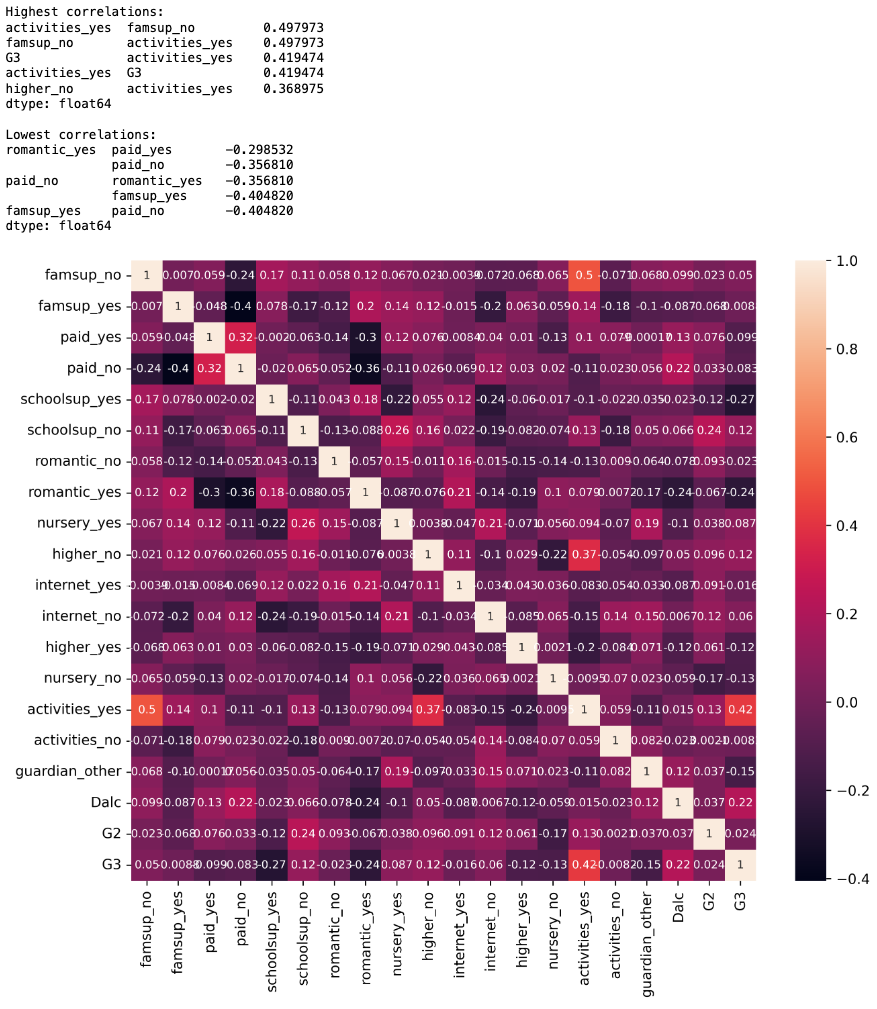

Even though we trained the NN with the results of our PCA, the model is still not very good. We manually selected the solver as 'sgd' and the activation function as 'relu', which both tend to be defaults for MLPRegressor. While our MSE is much improved, our R2 value is negative. This can be a sign of overfitting, as the model's predictions are poor and could be overly complex.

Parameter tuning, which runs many iterations of the MLPregressor with different parameters, helps a great deal in this regard, as we are able to further minimize our MSE. However, a point of concern is that our R2 value is still quite low. This is why we ultimately did not decide to go with the NN as our final model.

# NN with PCA

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor

In [3]:
#Load Data
data1 = pd.read_csv("student-por-PCA.csv")
data1.head(n=5)

,guardian_other,famsup_no,nursery_yes,internet_yes,higher_yes,higher_no,internet_no,romantic_yes,romantic_no,nursery_no,activities_yes,activities_no,paid_yes,paid_no,famsup_yes,schoolsup_yes,schoolsup_no,freetime,Walc,G3
0,-0.487793,1.261059,-0.008558,0.047022,2.478437,-1.448781,1.238804,0.444410,0.944119,1.847590,-0.774024,-0.671197,2.495119,-1.290842,2.176211,1.482553,1.353755,1.488881,0.017739,1.028555
1,0.366217,-0.230101,0.049356,-0.268528,0.789482,0.165044,-0.412277,-1.142196,0.951689,1.294938,-0.095692,0.059871,-0.835388,1.000542,0.087806,0.463302,0.012612,-0.395402,-1.557810,0.688669
2,0.419641,1.703424,-1.215843,-1.326990,0.412041,-1.399658,0.936363,0.507047,-0.430262,0.397546,-0.740888,0.468366,-0.132854,1.018273,1.972342,1.160121,1.065046,-1.073783,0.541808,1.555696
3,0.826359,-0.028700,0.728583,1.721021,-0.068260,0.521360,1.082719,-1.138684,-0.200349,0.169950,-0.733020,-0.039365,-0.182828,1.078593,-0.655445,-1.873547,0.930557,-0.238429,1.079587,-0.811982
4,-0.834214,1.264115,-0.260285,0.824680,0.468519,-0.313711,-0.776098,-1.114451,-0.275143,0.685987,-0.328803,0.278913,-0.309454,0.447325,-0.675908,1.907989,0.442039,-0.903695,0.895079,0.116149


In [4]:
from sklearn import preprocessing
Label = preprocessing.LabelEncoder()

G3 = Label.fit_transform(data1['G3'])

In [5]:
# Seperate our attributes into their respective input/output variables
X = data1[['activities_yes', 'activities_no', 'famsup_yes', 
         'famsup_no','higher_yes', 'higher_no']]
y = data1['G3']

# Split the dataset into test and train data respectively
X_train, X_test, y_train, y_test = train_test_split( 
             X, y, test_size = 0.2, random_state=42)

In [6]:
# Scale data using MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(solver = 'sgd', random_state = 42, activation = 'relu', learning_rate_init = 0.01, batch_size = 100, hidden_layer_sizes = (10, 10), max_iter = 1000)
mlp.fit(X_train_scaled, y_train.ravel())

MLPRegressor(batch_size=100, hidden_layer_sizes=(10, 10),
             learning_rate_init=0.01, max_iter=1000, random_state=42,
             solver='sgd')

In [7]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Predict and compute the error
mlp_pred = mlp.predict(X_test)

mse = mean_squared_error(y_test, mlp_pred)
mae = mean_absolute_error(y_test, mlp_pred)
r2 = r2_score(y_test, mlp_pred)

# Compute error
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 0.9542912105901241
MAE: 0.7747975500562101
R2: -0.2759789123285672


# Hypertuned NN

In [8]:
from sklearn.model_selection import GridSearchCV

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Define a grid of parameters over which to optimize the MLP
parameter_space = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

mlp = MLPRegressor(max_iter=1000, random_state=42)

# Run grid search with cross-validation
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train_scaled, y_train)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (+/-{std * 2:.3f}) for {params}")

# Making predictions with the best found parameters
pred = clf.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"Optimized Mean Square Error: {mse}")
print(f"Optimized R2 Score: {r2}")


Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
-0.012 (+/-0.081) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}
-0.025 (+/-0.091) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam'}
-0.012 (+/-0.081) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
-0.025 (+/-0.091) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}
-0.001 (+/-0.093) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'sgd'}
-0.003 (+/-0.076) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
-0.002 (+/-0.093) for {'activation': 

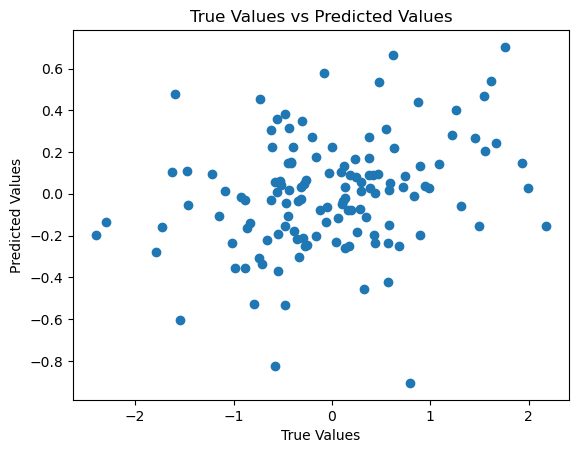

MSE: 0.9542912105901241
MAE: 0.7747975500562101
R2: -0.2759789123285672
Optimized Mean Squared Error: 0.6931026000683201
Optimized R2 Score: 0.073255320857055


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_test and pred are already defined
# Making predictions with the best found parameters
pred = clf.predict(X_test)

# Scatter plot of true vs predicted values
plt.scatter(y_test, pred)
plt.title('True Values vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Evaluating the model
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"MSE: 0.9542912105901241")
print(f"MAE: 0.7747975500562101")
print(f"R2: -0.2759789123285672")
print(f"Optimized Mean Squared Error: {mse}")
print(f"Optimized R2 Score: {r2}")